# TESS Atlas fit for TOI 416

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 416.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-416.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-416.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-416.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 416

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 416 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

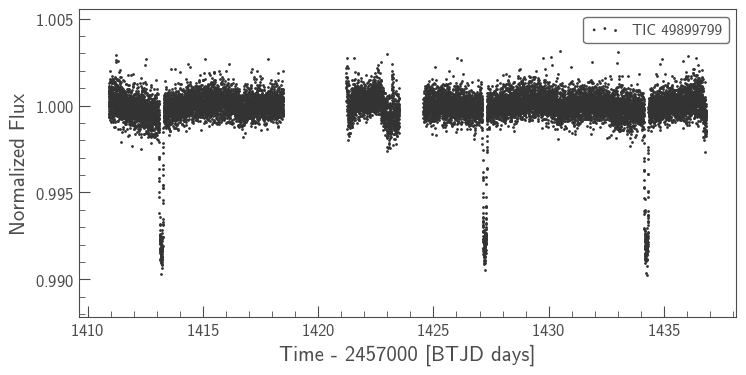

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -25369.32616430451 -> -23065.343730451295


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -14573.705449693587 -> -13476.65803371599


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -13476.658033715978 -> -13343.172281345203


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -13343.172281345203 -> -13343.116650403552


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -13343.116650403552 -> -13338.587332885743


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -13338.587332885743 -> -13338.515548776331


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -13338.515548776331 -> -13274.118657178204


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -13274.118657178204 -> -13274.118657178153


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -13274.118657178153 -> -13274.118657178116


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -13274.118657178116 -> -13274.118657178109


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -13274.118657178109 -> -13274.118657178109


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -13274.118657178109 -> -13274.118657178109


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -13274.118657178109 -> -13274.118657178109


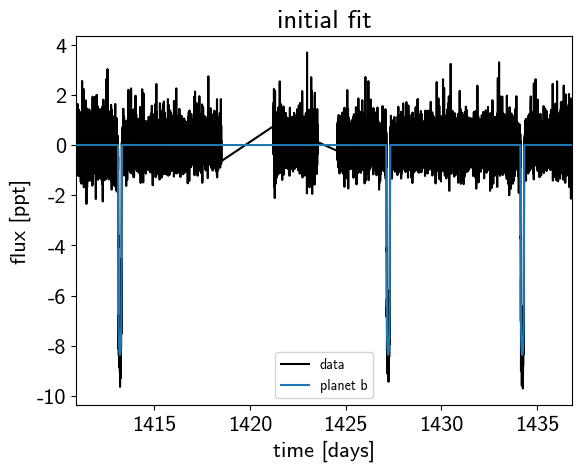

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:06, 14.77draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:00<00:07, 12.36draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:21,  4.27draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:22,  4.01draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:20,  4.35draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:23,  3.71draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:25,  3.42draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:24,  3.43draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:26,  3.16draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:24,  3.43draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:27,  2.94draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:22,  3.68draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:29,  2.74draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:23,  3.35draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:31,  2.51draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:24,  3.10draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:29,  2.56draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:26,  2.82draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:27,  2.70draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:25,  2.82draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:26,  2.68draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:21,  3.26draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:26,  2.68draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:19,  3.54draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:23,  2.79draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:21,  3.01draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:17,  3.70draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:22,  2.78draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:10<00:18,  3.43draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:11<00:23,  2.56draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:11<00:20,  2.99draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:20,  2.91draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:12<00:18,  3.17draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:12<00:18,  3.12draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:12<00:17,  3.13draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:13<00:19,  2.81draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:13<00:16,  3.19draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:13<00:14,  3.63draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:13<00:13,  3.73draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:14<00:16,  2.96draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:14<00:13,  3.54draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:15<00:18,  2.66draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:15<00:14,  3.31draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:15<00:16,  2.73draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:16<00:15,  2.86draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:16<00:17,  2.55draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:16<00:13,  3.25draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:17<00:16,  2.52draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:17<00:15,  2.66draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:18<00:11,  3.29draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:18<00:13,  2.80draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:18<00:12,  2.88draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:19<00:12,  2.91draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:19<00:11,  3.02draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:19<00:11,  2.95draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:20<00:10,  3.02draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:20<00:11,  2.74draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:21<00:10,  2.87draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:21<00:09,  3.04draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:22<00:08,  3.01draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:22<00:06,  3.69draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:23<00:08,  2.96draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:23<00:06,  3.72draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:23<00:07,  2.75draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:24<00:07,  2.82draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:24<00:05,  3.44draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:25<00:06,  2.78draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:25<00:05,  2.90draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:26<00:04,  2.99draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:26<00:03,  3.74draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:27<00:04,  2.92draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:27<00:03,  3.00draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:27<00:03,  3.17draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:28<00:03,  2.86draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:28<00:02,  3.39draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:28<00:02,  2.88draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:29<00:01,  2.99draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:29<00:00,  3.04draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:30<00:00,  2.33draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:31<00:00,  1.64draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:33<00:00,  1.18draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:06, 14.21draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:00<00:09, 10.20draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:24,  3.69draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:22,  3.94draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:28,  3.10draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:29,  3.02draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:29,  2.92draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:27,  3.14draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:24,  3.48draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:22,  3.75draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:25,  3.25draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:29,  2.73draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:30,  2.66draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:26,  2.94draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:22,  3.46draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:30,  2.48draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:28,  2.57draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:24,  2.94draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:21,  3.27draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:22,  3.04draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:25,  2.68draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:20,  3.30draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:20,  3.21draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:20,  3.14draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:10<00:17,  3.54draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:11<00:20,  3.02draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:15,  3.74draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:11<00:19,  3.02draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:12<00:16,  3.50draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:12<00:19,  2.87draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:12<00:15,  3.58draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:13<00:19,  2.77draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:13<00:17,  3.11draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:13<00:18,  2.82draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:14<00:15,  3.15draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:14<00:13,  3.51draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:15<00:17,  2.81draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:15<00:15,  3.06draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:15<00:16,  2.81draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:16<00:15,  2.95draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:16<00:15,  2.85draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:16<00:15,  2.77draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:17<00:11,  3.43draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:17<00:13,  2.91draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:17<00:11,  3.44draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:18<00:13,  2.81draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:18<00:10,  3.50draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:18<00:13,  2.60draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:19<00:12,  2.71draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:20<00:11,  2.73draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:21<00:09,  3.06draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:21<00:08,  3.08draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:21<00:06,  3.81draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:22<00:08,  2.85draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:23<00:06,  3.16draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:23<00:06,  3.08draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:23<00:05,  3.51draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:24<00:03,  4.46draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:24<00:04,  3.92draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:25<00:05,  2.89draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:25<00:04,  2.88draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:25<00:03,  3.39draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:26<00:03,  2.88draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:26<00:03,  3.10draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:27<00:03,  2.70draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:27<00:02,  3.24draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:27<00:02,  2.76draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:27<00:01,  3.09draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:28<00:01,  2.90draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:29<00:01,  2.33draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:29<00:01,  2.02draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:30<00:01,  1.84draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:31<00:00,  1.67draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:33<00:00,  1.17s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:14,  2.71draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<01:08,  2.95draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<00:59,  3.39draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:05,  3.04draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:00,  3.25draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<00:58,  3.37draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:02<00:50,  3.89draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<00:38,  5.10draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:35,  5.47draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:02<00:29,  6.41draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:02<00:22,  8.26draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:03<00:27,  6.73draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:03<00:26,  6.88draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:03<00:24,  7.44draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:04<00:38,  4.70draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:04<00:36,  4.86draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:05<00:55,  3.20draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:05<00:42,  4.14draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:05<00:48,  3.59draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:05<00:36,  4.75draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:06<00:34,  4.91draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:06<00:42,  3.95draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:06<00:40,  4.12draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:06<00:42,  3.93draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:07<00:32,  5.12draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:07<00:34,  4.68draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:07<00:30,  5.36draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:08<00:38,  4.18draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:08<00:38,  4.08draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:08<00:33,  4.66draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:08<00:32,  4.78draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:08<00:32,  4.74draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:09<00:31,  4.87draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:09<00:37,  4.06draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:09<00:40,  3.81draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:10<00:42,  3.54draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:10<00:42,  3.59draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:10<00:48,  3.11draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:10<00:37,  3.94draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:11<00:30,  4.80draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:11<00:36,  3.98draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:11<00:27,  5.17draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:12<00:29,  4.82draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:12<00:25,  5.47draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:12<00:32,  4.25draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:13<00:27,  4.87draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:13<00:42,  3.18draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:13<00:34,  3.83draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:14<00:44,  2.92draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:14<00:33,  3.80draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:15<00:31,  4.00draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:15<00:29,  4.21draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:15<00:31,  3.93draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:15<00:25,  4.80draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:16<00:20,  6.04draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:16<00:15,  7.47draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:16<00:16,  6.90draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:17<00:18,  6.17draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:17<00:23,  4.68draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:18<00:22,  4.90draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:18<00:25,  4.21draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:18<00:19,  5.36draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:18<00:19,  5.36draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:19<00:18,  5.58draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:19<00:21,  4.85draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:19<00:22,  4.47draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:20<00:25,  3.85draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:20<00:22,  4.40draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:20<00:21,  4.66draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:21<00:26,  3.65draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:21<00:22,  4.30draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:21<00:18,  5.18draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:21<00:17,  5.35draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:21<00:14,  6.41draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:21<00:11,  7.83draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:22<00:10,  8.08draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:22<00:10,  8.29draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:22<00:18,  4.58draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:23<00:20,  4.01draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:23<00:27,  2.91draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:23<00:20,  3.77draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:24<00:15,  4.87draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:24<00:16,  4.60draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:24<00:14,  5.31draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:24<00:10,  6.72draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:24<00:10,  6.66draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:25<00:09,  6.99draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:25<00:09,  7.17draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:25<00:13,  5.04draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:25<00:12,  5.37draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:26<00:14,  4.57draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:26<00:15,  3.93draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:27<00:14,  4.23draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:27<00:11,  5.02draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:27<00:13,  4.49draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:27<00:12,  4.54draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:28<00:10,  5.04draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:28<00:13,  4.09draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:28<00:09,  5.06draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:29<00:11,  4.33draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:29<00:08,  5.44draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:29<00:08,  5.46draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:29<00:08,  5.12draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:30<00:11,  3.78draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:30<00:09,  4.36draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:30<00:07,  4.90draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:31<00:07,  4.65draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:31<00:06,  5.30draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:31<00:04,  6.73draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:31<00:04,  7.10draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:31<00:03,  8.00draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:32<00:04,  5.65draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:32<00:05,  4.96draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:32<00:04,  5.44draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:33<00:04,  5.36draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:33<00:04,  4.46draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:33<00:04,  4.77draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:33<00:04,  4.15draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:34<00:03,  4.84draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:34<00:04,  4.19draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:35<00:05,  3.09draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:35<00:03,  3.84draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:35<00:03,  3.80draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:35<00:03,  3.64draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:36<00:03,  3.13draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:36<00:02,  4.11draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:37<00:02,  2.77draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:37<00:03,  2.31draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:38<00:02,  2.07draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:38<00:02,  1.93draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:38<00:01,  2.49draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:39<00:00,  3.07draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:39<00:00,  3.75draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:39<00:00,  2.69draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:40<00:00,  3.06draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:09, 42.50draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:08, 43.75draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:00<00:07, 48.61draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:00<00:07, 53.07draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:00<00:06, 56.08draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:00<00:06, 58.21draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:00<00:06, 55.60draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:00<00:06, 54.74draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:01<00:06, 55.33draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:01<00:05, 59.55draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:01<00:06, 55.15draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:01<00:05, 58.00draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:01<00:05, 55.19draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:01<00:05, 59.59draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:01<00:04, 62.32draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:01<00:04, 66.60draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:01<00:04, 62.78draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:02<00:04, 57.68draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:02<00:04, 57.61draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:02<00:04, 60.43draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:02<00:03, 64.95draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:02<00:03, 71.16draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:02<00:03, 71.42draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:02<00:03, 75.59draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:02<00:02, 76.60draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [00:02<00:02, 79.83draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:03<00:02, 83.81draws/s]

Sampling 2 chains:  52%|█████▏    | 212/404 [00:03<00:02, 82.89draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:03<00:02, 84.14draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:03<00:02, 79.39draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:03<00:02, 81.59draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:03<00:02, 75.84draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:03<00:01, 75.60draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:03<00:01, 72.76draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:04<00:01, 76.21draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [00:04<00:01, 77.15draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [00:04<00:01, 75.64draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:04<00:01, 71.94draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:04<00:01, 75.99draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [00:04<00:01, 74.33draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:04<00:01, 78.75draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:04<00:00, 81.01draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:04<00:00, 82.73draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:05<00:00, 87.81draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:05<00:00, 88.60draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:05<00:00, 92.12draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:05<00:00, 92.72draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:05<00:00, 80.04draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:05<00:00, 71.63draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<00:20, 38.69draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<00:19, 40.05draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:17, 45.17draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:00<00:16, 45.95draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:00<00:15, 49.41draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:00<00:16, 47.28draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:00<00:14, 51.60draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:01<00:18, 40.63draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:01<00:18, 41.46draws/s]

Sampling 2 chains:   7%|▋         | 57/804 [00:01<00:17, 42.27draws/s]

Sampling 2 chains:   8%|▊         | 62/804 [00:01<00:19, 37.17draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:01<00:18, 39.90draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:01<00:17, 41.75draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:01<00:14, 49.34draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:01<00:14, 48.95draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:02<00:13, 54.25draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:02<00:13, 50.13draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:02<00:13, 51.67draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:02<00:12, 55.33draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:02<00:12, 54.48draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:02<00:11, 58.22draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:02<00:11, 55.75draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:02<00:11, 58.46draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:02<00:10, 63.24draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:03<00:09, 66.29draws/s]

Sampling 2 chains:  21%|██        | 170/804 [00:03<00:09, 67.27draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:03<00:09, 67.80draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:03<00:09, 62.84draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:03<00:08, 70.24draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [00:03<00:08, 70.96draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:03<00:09, 65.68draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:03<00:08, 69.66draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:04<00:08, 65.01draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:04<00:09, 60.87draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:04<00:09, 57.77draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:04<00:09, 59.63draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:04<00:08, 62.37draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [00:04<00:08, 66.29draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:04<00:07, 70.77draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:05<00:09, 56.18draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:05<00:08, 58.29draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:05<00:08, 62.46draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [00:05<00:07, 64.53draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:05<00:07, 63.46draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:05<00:08, 54.89draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:05<00:08, 54.86draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:05<00:08, 56.91draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:05<00:07, 64.03draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:06<00:07, 63.48draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:06<00:06, 63.69draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [00:06<00:07, 62.10draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [00:06<00:06, 62.53draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:06<00:06, 63.95draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:06<00:06, 66.35draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [00:06<00:05, 71.91draws/s]

Sampling 2 chains:  50%|█████     | 406/804 [00:06<00:05, 66.36draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:06<00:06, 64.53draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:07<00:05, 65.69draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:07<00:05, 68.96draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [00:07<00:04, 75.07draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [00:07<00:04, 78.07draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:07<00:04, 75.06draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:07<00:04, 70.15draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:07<00:04, 71.85draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:07<00:04, 72.84draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:08<00:04, 65.54draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [00:08<00:04, 63.10draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [00:08<00:04, 60.21draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:08<00:05, 57.30draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:08<00:04, 60.21draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:08<00:04, 56.59draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [00:08<00:04, 59.81draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:08<00:04, 62.48draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [00:09<00:03, 69.25draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:09<00:03, 69.74draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:09<00:03, 76.33draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:09<00:02, 78.75draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:09<00:02, 78.98draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:09<00:02, 72.42draws/s]

Sampling 2 chains:  76%|███████▌  | 608/804 [00:09<00:02, 71.39draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:09<00:02, 73.02draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:10<00:02, 66.83draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:10<00:02, 67.17draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:10<00:02, 56.28draws/s]

Sampling 2 chains:  80%|████████  | 647/804 [00:10<00:02, 58.78draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:10<00:02, 59.39draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:10<00:02, 63.85draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:10<00:02, 65.53draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:10<00:01, 65.91draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:10<00:01, 69.63draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:11<00:01, 71.46draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:11<00:01, 69.36draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [00:11<00:01, 64.84draws/s]

Sampling 2 chains:  89%|████████▉ | 719/804 [00:11<00:01, 66.25draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [00:11<00:01, 68.08draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [00:11<00:00, 73.01draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [00:11<00:00, 72.96draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [00:11<00:00, 68.02draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:12<00:00, 70.75draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [00:12<00:00, 65.68draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:12<00:00, 51.34draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [00:12<00:00, 44.34draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [00:12<00:00, 41.17draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [00:12<00:00, 31.10draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:13<00:00, 25.43draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:13<00:00, 27.78draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:13<00:00, 59.87draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/4404 [00:00<01:52, 39.23draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<02:02, 35.82draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<02:00, 36.44draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:00<02:01, 36.24draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:00<01:49, 39.88draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:00<02:04, 35.14draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:00<02:06, 34.45draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:00<02:14, 32.48draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:01<02:10, 33.35draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:01<01:54, 38.09draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:01<01:56, 37.31draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:01<03:09, 22.92draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:01<03:10, 22.87draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:01<02:56, 24.55draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:02<02:47, 25.87draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:02<02:32, 28.48draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:02<02:15, 31.94draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:02<01:57, 36.88draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:02<01:48, 39.72draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:02<01:37, 44.39draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:02<01:47, 40.02draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:02<01:43, 41.58draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:03<01:38, 43.46draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:03<01:33, 45.94draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:03<01:49, 39.02draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:03<01:51, 38.54draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:03<01:55, 36.93draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:03<01:50, 38.82draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:03<01:36, 44.03draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:03<01:32, 46.16draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:04<01:49, 38.86draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:04<01:47, 39.54draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:04<01:38, 43.27draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:04<01:38, 43.06draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:04<01:47, 39.49draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:04<01:42, 41.25draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:04<01:35, 44.09draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:04<01:32, 45.60draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:05<01:33, 45.22draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:05<01:27, 48.02draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:05<01:25, 49.11draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:05<01:45, 39.60draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:05<01:44, 39.88draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:05<01:42, 40.68draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:05<01:37, 43.02draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:05<01:33, 44.60draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:06<01:31, 45.57draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:06<01:29, 46.72draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:06<01:27, 47.50draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [00:06<01:22, 50.06draws/s]

Sampling 2 chains:   6%|▌         | 265/4404 [00:06<01:17, 53.62draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:06<01:21, 50.42draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [00:06<01:15, 54.28draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:06<01:18, 52.38draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:07<01:28, 46.38draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [00:07<01:27, 46.73draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:07<01:28, 46.15draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:07<01:29, 45.97draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [00:07<01:30, 45.42draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:07<01:28, 45.90draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:07<01:28, 46.35draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:08<01:53, 35.96draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [00:08<02:01, 33.37draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:08<02:01, 33.55draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:08<02:01, 33.38draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:08<02:13, 30.32draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:08<02:04, 32.61draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:08<01:56, 34.65draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:08<01:51, 36.23draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:09<01:48, 37.28draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:09<01:43, 39.14draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:09<01:37, 41.15draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:09<01:35, 42.13draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:09<01:34, 42.60draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:09<01:33, 42.85draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [00:09<02:06, 31.72draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:09<02:06, 31.74draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:10<01:53, 35.20draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:10<01:38, 40.35draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:10<01:36, 41.48draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:10<01:32, 42.85draws/s]

Sampling 2 chains:  10%|▉         | 428/4404 [00:10<01:32, 43.10draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:10<01:27, 45.14draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:10<01:32, 42.77draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [00:10<01:31, 43.42draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:11<01:24, 46.66draws/s]

Sampling 2 chains:  10%|█         | 457/4404 [00:11<01:22, 47.99draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [00:11<01:11, 55.19draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:11<01:07, 58.63draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:11<01:07, 58.09draws/s]

Sampling 2 chains:  11%|█         | 487/4404 [00:11<01:21, 47.82draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:11<01:30, 43.33draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:11<01:28, 44.03draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:12<01:29, 43.58draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:12<01:28, 44.16draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:12<01:26, 44.82draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:12<01:22, 47.25draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [00:12<01:19, 48.96draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:12<01:21, 47.80draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:12<01:20, 48.27draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:12<01:14, 51.75draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:13<01:24, 45.65draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:13<01:25, 44.91draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:13<01:23, 45.97draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:13<01:18, 48.77draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:13<01:28, 43.23draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:13<01:35, 39.99draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:13<01:46, 35.83draws/s]

Sampling 2 chains:  13%|█▎        | 585/4404 [00:13<01:39, 38.20draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [00:14<01:49, 34.98draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:14<01:41, 37.50draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:14<01:37, 39.04draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:14<01:32, 41.07draws/s]

Sampling 2 chains:  14%|█▍        | 612/4404 [00:14<01:27, 43.12draws/s]

Sampling 2 chains:  14%|█▍        | 618/4404 [00:14<01:24, 44.83draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:14<01:21, 46.23draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [00:14<01:26, 43.59draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [00:15<01:25, 44.32draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [00:15<01:18, 47.82draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:15<01:17, 48.45draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:15<01:17, 48.65draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:15<01:11, 52.16draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [00:15<01:16, 48.75draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [00:15<01:19, 47.27draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [00:15<01:21, 45.89draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:16<01:18, 47.66draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:16<01:15, 49.31draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [00:16<01:27, 42.30draws/s]

Sampling 2 chains:  16%|█▌        | 696/4404 [00:16<01:41, 36.58draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [00:16<01:41, 36.53draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [00:16<01:39, 37.00draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [00:16<01:30, 40.90draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:16<01:26, 42.82draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [00:17<01:29, 41.20draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:17<01:24, 43.28draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [00:17<01:19, 46.15draws/s]

Sampling 2 chains:  17%|█▋        | 738/4404 [00:17<01:17, 47.16draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:17<01:16, 47.82draws/s]

Sampling 2 chains:  17%|█▋        | 749/4404 [00:17<01:18, 46.52draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [00:17<01:23, 43.71draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [00:17<01:15, 48.45draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [00:17<01:17, 47.21draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [00:18<01:19, 45.57draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [00:18<01:20, 44.85draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:18<01:15, 48.21draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [00:18<01:17, 46.83draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [00:18<01:15, 47.68draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [00:18<01:31, 39.50draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [00:18<01:29, 40.32draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [00:19<01:50, 32.45draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [00:19<01:47, 33.46draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [00:19<01:45, 33.91draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:19<01:44, 34.16draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [00:19<01:43, 34.62draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [00:19<01:47, 33.33draws/s]

Sampling 2 chains:  19%|█▉        | 834/4404 [00:19<01:38, 36.13draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:19<01:39, 35.94draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [00:19<01:37, 36.65draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [00:20<01:32, 38.35draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:20<01:29, 39.82draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [00:20<01:28, 39.93draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [00:20<01:20, 43.76draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [00:20<01:23, 42.39draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:20<01:16, 46.11draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:20<01:12, 48.59draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [00:20<01:12, 48.20draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [00:21<01:14, 47.12draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [00:21<01:12, 48.23draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [00:21<01:12, 48.15draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [00:21<01:13, 47.81draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [00:21<01:17, 44.91draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [00:21<01:22, 42.28draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [00:21<01:31, 38.14draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [00:21<01:33, 37.36draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [00:22<01:26, 40.33draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [00:22<01:21, 42.53draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [00:22<01:21, 42.64draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [00:22<01:22, 41.89draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [00:22<01:18, 43.85draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [00:22<01:27, 39.32draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [00:22<01:25, 40.20draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:22<01:20, 42.48draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [00:23<01:14, 45.76draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [00:23<01:15, 45.35draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [00:23<01:13, 46.80draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [00:23<01:12, 46.84draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [00:23<01:11, 47.76draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:23<01:16, 44.52draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [00:23<01:14, 45.28draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [00:23<01:10, 48.22draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [00:23<01:09, 48.49draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [00:24<01:15, 44.78draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [00:24<01:18, 42.94draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [00:24<01:15, 44.74draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [00:24<01:22, 40.92draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [00:24<01:17, 43.23draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [00:24<01:17, 43.09draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [00:24<01:15, 44.62draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [00:24<01:15, 44.50draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [00:24<01:17, 42.85draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [00:25<01:15, 43.93draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [00:25<01:14, 44.86draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [00:25<01:14, 44.42draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [00:25<01:15, 43.72draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [00:25<01:15, 44.12draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [00:25<01:18, 42.06draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [00:25<01:17, 42.42draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [00:25<01:15, 43.81draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [00:26<01:13, 44.64draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [00:26<01:11, 45.90draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [00:26<01:21, 40.30draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [00:26<01:12, 45.26draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [00:26<01:14, 43.80draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [00:26<01:14, 43.79draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [00:26<01:09, 47.19draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [00:26<01:10, 46.29draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [00:27<01:05, 49.47draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [00:27<01:07, 48.31draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [00:27<01:08, 47.34draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [00:27<01:10, 45.54draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [00:27<01:15, 42.75draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [00:27<01:14, 43.22draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [00:27<01:12, 44.50draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [00:27<01:10, 45.27draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [00:28<01:21, 39.32draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [00:28<01:23, 38.39draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [00:28<01:19, 39.95draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [00:28<01:16, 41.62draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [00:28<01:14, 42.81draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [00:28<01:14, 42.91draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [00:28<01:12, 43.55draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [00:28<01:08, 46.21draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [00:28<01:05, 48.53draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [00:29<01:02, 50.48draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [00:29<01:05, 48.25draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [00:29<01:08, 45.92draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [00:29<01:11, 43.94draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [00:29<01:08, 45.71draws/s]

Sampling 2 chains:  29%|██▉       | 1277/4404 [00:29<01:07, 46.66draws/s]

Sampling 2 chains:  29%|██▉       | 1284/4404 [00:29<01:01, 50.34draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [00:29<01:05, 47.68draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [00:30<01:10, 43.94draws/s]

Sampling 2 chains:  30%|██▉       | 1300/4404 [00:30<01:16, 40.60draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [00:30<01:13, 42.21draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [00:30<01:21, 37.79draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [00:30<01:15, 40.66draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [00:30<01:18, 39.22draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [00:30<01:19, 38.86draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [00:31<01:11, 43.16draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [00:31<01:20, 38.11draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [00:31<01:18, 39.24draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [00:31<01:24, 36.17draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [00:31<01:19, 38.23draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [00:31<01:22, 37.06draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [00:31<01:23, 36.41draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [00:31<01:21, 37.33draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [00:32<01:23, 36.52draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [00:32<01:25, 35.53draws/s]

Sampling 2 chains:  31%|███▏      | 1378/4404 [00:32<01:22, 36.76draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [00:32<01:23, 36.40draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [00:32<01:18, 38.62draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [00:32<01:20, 37.63draws/s]

Sampling 2 chains:  32%|███▏      | 1396/4404 [00:32<01:16, 39.11draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [00:32<01:18, 38.10draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [00:32<01:15, 39.69draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [00:33<01:16, 39.21draws/s]

Sampling 2 chains:  32%|███▏      | 1416/4404 [00:33<01:11, 42.08draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [00:33<01:06, 44.66draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [00:33<01:05, 45.68draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [00:33<01:02, 47.29draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [00:33<00:57, 51.54draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [00:33<00:58, 50.90draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [00:33<00:55, 52.79draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [00:34<00:54, 54.51draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [00:34<00:56, 52.25draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [00:34<00:58, 49.73draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [00:34<01:00, 48.16draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [00:34<01:01, 47.35draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [00:34<01:03, 45.93draws/s]

Sampling 2 chains:  34%|███▍      | 1495/4404 [00:34<01:01, 47.05draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [00:34<01:00, 47.72draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [00:35<00:57, 49.98draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [00:35<00:59, 48.50draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [00:35<01:01, 46.79draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [00:35<01:02, 46.00draws/s]

Sampling 2 chains:  35%|███▍      | 1529/4404 [00:35<00:59, 48.08draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [00:35<01:01, 46.69draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [00:35<01:02, 45.89draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [00:35<01:00, 47.34draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [00:35<01:02, 45.96draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [00:36<01:02, 45.24draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [00:36<00:59, 47.43draws/s]

Sampling 2 chains:  36%|███▌      | 1566/4404 [00:36<01:06, 42.62draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [00:36<01:05, 43.42draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [00:36<01:05, 43.35draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [00:36<01:02, 45.05draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [00:36<01:03, 44.57draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [00:36<01:07, 41.64draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [00:37<01:14, 37.90draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [00:37<01:14, 37.65draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [00:37<01:15, 37.00draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [00:37<01:13, 37.80draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [00:37<01:13, 38.08draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [00:37<01:14, 37.47draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [00:37<01:11, 38.68draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [00:37<01:08, 40.49draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [00:37<01:01, 44.80draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [00:38<00:58, 47.62draws/s]

Sampling 2 chains:  37%|███▋      | 1645/4404 [00:38<00:56, 48.91draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [00:38<00:54, 50.47draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [00:38<00:54, 50.71draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [00:38<00:50, 54.52draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [00:38<00:49, 54.71draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [00:38<00:50, 54.53draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [00:38<00:48, 55.97draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [00:38<00:49, 55.19draws/s]

Sampling 2 chains:  39%|███▊      | 1698/4404 [00:39<00:47, 56.92draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [00:39<00:49, 54.04draws/s]

Sampling 2 chains:  39%|███▉      | 1710/4404 [00:39<00:50, 53.30draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [00:39<00:50, 52.72draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [00:39<00:48, 55.74draws/s]

Sampling 2 chains:  39%|███▉      | 1729/4404 [00:39<00:50, 53.33draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [00:39<00:51, 51.52draws/s]

Sampling 2 chains:  40%|███▉      | 1742/4404 [00:39<00:47, 55.73draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [00:40<00:50, 52.32draws/s]

Sampling 2 chains:  40%|███▉      | 1755/4404 [00:40<00:48, 55.07draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [00:40<00:49, 53.68draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [00:40<00:46, 57.01draws/s]

Sampling 2 chains:  40%|████      | 1774/4404 [00:40<00:50, 52.22draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [00:40<00:48, 54.09draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [00:40<00:50, 52.19draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [00:40<01:02, 41.85draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [00:41<01:00, 43.41draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [00:41<00:59, 43.88draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [00:41<00:57, 44.91draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [00:41<00:56, 45.68draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [00:41<00:55, 46.88draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [00:41<00:55, 46.53draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [00:41<00:53, 48.25draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [00:41<00:52, 48.99draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [00:42<00:50, 50.28draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [00:42<00:51, 49.65draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [00:42<00:51, 49.41draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [00:42<00:52, 48.53draws/s]

Sampling 2 chains:  42%|████▏     | 1867/4404 [00:42<00:49, 50.95draws/s]

Sampling 2 chains:  43%|████▎     | 1873/4404 [00:42<00:47, 53.09draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [00:42<00:47, 52.81draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [00:42<00:46, 54.49draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [00:42<00:45, 55.22draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [00:43<00:42, 58.44draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [00:43<00:46, 53.93draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [00:43<00:46, 53.97draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [00:43<00:45, 55.00draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [00:43<00:47, 51.77draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [00:43<00:50, 49.44draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [00:43<00:47, 51.75draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [00:43<00:48, 51.13draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [00:43<00:48, 51.10draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [00:44<00:45, 53.65draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [00:44<00:45, 53.65draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [00:44<00:46, 52.49draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [00:44<00:48, 50.57draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [00:44<00:48, 50.05draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [00:44<00:47, 50.52draws/s]

Sampling 2 chains:  45%|████▌     | 1992/4404 [00:44<00:45, 53.36draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [00:44<00:49, 48.92draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [00:45<00:48, 49.46draws/s]

Sampling 2 chains:  46%|████▌     | 2010/4404 [00:45<00:46, 51.62draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [00:45<00:46, 50.85draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [00:45<00:43, 55.22draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [00:45<00:47, 49.61draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [00:45<00:52, 45.31draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [00:45<00:53, 44.26draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [00:45<00:54, 43.40draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [00:46<00:51, 45.54draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [00:46<00:51, 45.88draws/s]

Sampling 2 chains:  47%|████▋     | 2061/4404 [00:46<00:52, 44.28draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [00:46<00:52, 44.93draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [00:46<00:50, 45.77draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [00:46<00:49, 46.96draws/s]

Sampling 2 chains:  47%|████▋     | 2081/4404 [00:46<00:50, 46.18draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [00:46<00:56, 40.85draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [00:47<00:56, 40.72draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [00:47<00:57, 40.43draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [00:47<00:54, 42.29draws/s]

Sampling 2 chains:  48%|████▊     | 2106/4404 [00:47<00:52, 43.50draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [00:47<00:52, 43.99draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [00:47<00:56, 40.60draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [00:47<00:55, 41.48draws/s]

Sampling 2 chains:  48%|████▊     | 2126/4404 [00:47<00:56, 40.60draws/s]

Sampling 2 chains:  48%|████▊     | 2132/4404 [00:47<00:54, 41.45draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [00:48<00:49, 45.65draws/s]

Sampling 2 chains:  49%|████▊     | 2143/4404 [00:48<00:52, 43.04draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [00:48<00:58, 38.36draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [00:48<00:58, 38.48draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [00:48<00:58, 38.41draws/s]

Sampling 2 chains:  49%|████▉     | 2164/4404 [00:48<00:52, 42.81draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [00:48<00:49, 45.37draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [00:48<00:48, 45.73draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [00:49<00:47, 46.55draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [00:49<00:48, 45.46draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [00:49<00:47, 46.57draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [00:49<00:45, 48.88draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [00:49<00:45, 48.64draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [00:49<00:43, 49.92draws/s]

Sampling 2 chains:  50%|█████     | 2214/4404 [00:49<00:43, 50.68draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [00:49<00:44, 49.52draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [00:49<00:41, 52.84draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [00:50<00:39, 54.37draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [00:50<00:36, 58.66draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [00:50<00:37, 57.60draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [00:50<00:37, 57.14draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [00:50<00:40, 52.66draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [00:50<00:41, 51.84draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [00:50<00:43, 49.15draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [00:50<00:41, 50.94draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [00:51<00:44, 47.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [00:51<00:42, 49.21draws/s]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [00:51<00:42, 49.04draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [00:51<00:42, 48.94draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [00:51<00:50, 41.91draws/s]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [00:51<00:50, 41.79draws/s]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [00:51<00:46, 45.01draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [00:51<00:46, 45.15draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [00:52<00:45, 45.73draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [00:52<00:42, 48.96draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [00:52<00:41, 50.18draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [00:52<00:39, 51.77draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [00:52<00:37, 55.12draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [00:52<00:35, 58.02draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [00:52<00:44, 46.12draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [00:52<00:41, 49.06draws/s]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [00:52<00:39, 51.40draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [00:53<00:41, 49.19draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [00:53<00:40, 49.23draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [00:53<00:39, 50.86draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [00:53<00:38, 51.36draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [00:53<00:37, 52.86draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [00:53<00:39, 50.30draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [00:53<00:40, 49.14draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [00:53<00:39, 50.18draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [00:54<00:40, 48.81draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [00:54<00:42, 46.68draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [00:54<00:41, 47.54draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [00:54<00:41, 46.92draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [00:54<00:41, 47.04draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [00:54<00:42, 46.28draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [00:54<00:40, 47.37draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [00:54<00:41, 46.07draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [00:54<00:41, 46.79draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [00:55<00:41, 45.97draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [00:55<00:42, 45.42draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [00:55<00:42, 45.27draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [00:55<00:42, 44.98draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [00:55<00:43, 43.61draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [00:55<00:43, 43.89draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [00:55<00:43, 43.86draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [00:55<00:41, 45.32draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [00:55<00:38, 48.70draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [00:56<00:43, 43.04draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [00:56<00:45, 40.91draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [00:56<00:44, 42.00draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [00:56<00:45, 41.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [00:56<00:43, 43.02draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [00:56<00:43, 42.34draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [00:56<00:43, 42.30draws/s]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [00:56<00:44, 41.81draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [00:57<00:41, 43.86draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [00:57<00:41, 44.00draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [00:57<00:38, 47.45draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [00:57<00:38, 47.58draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [00:57<00:37, 48.72draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [00:57<00:36, 49.06draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [00:57<00:36, 49.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [00:57<00:35, 50.16draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [00:57<00:34, 52.24draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [00:58<00:35, 50.20draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [00:58<00:35, 50.78draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [00:58<00:37, 47.82draws/s]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [00:58<00:36, 48.15draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [00:58<00:36, 47.66draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [00:58<00:36, 47.84draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [00:58<00:35, 48.77draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [00:58<00:35, 49.64draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [00:59<00:35, 49.43draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [00:59<00:36, 48.07draws/s]

Sampling 2 chains:  61%|██████    | 2678/4404 [00:59<00:35, 48.08draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [00:59<00:36, 47.07draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [00:59<00:39, 42.94draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [00:59<00:39, 43.40draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [00:59<00:39, 43.47draws/s]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [00:59<00:41, 41.34draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [01:00<00:40, 41.67draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [01:00<00:38, 43.93draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [01:00<00:36, 46.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [01:00<00:36, 45.67draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [01:00<00:36, 45.49draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [01:00<00:34, 47.83draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [01:00<00:35, 46.22draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [01:00<00:34, 47.27draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [01:01<00:36, 45.38draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [01:01<00:32, 50.30draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [01:01<00:33, 48.13draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [01:01<00:33, 48.46draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [01:01<00:32, 50.12draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [01:01<00:31, 50.98draws/s]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [01:01<00:35, 45.49draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [01:01<00:36, 44.07draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [01:02<00:38, 41.58draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [01:02<00:38, 41.81draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [01:02<00:40, 39.27draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [01:02<00:37, 42.09draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [01:02<00:38, 41.62draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [01:02<00:43, 36.07draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [01:02<00:40, 38.85draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [01:02<00:38, 40.88draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [01:03<00:36, 42.30draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [01:03<00:37, 41.44draws/s]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [01:03<00:35, 43.56draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [01:03<00:32, 48.15draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [01:03<00:33, 46.47draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [01:03<00:36, 42.23draws/s]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [01:03<00:35, 42.77draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [01:03<00:32, 46.30draws/s]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [01:04<00:32, 46.58draws/s]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [01:04<00:33, 45.23draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [01:04<00:33, 45.04draws/s]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [01:04<00:33, 45.37draws/s]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [01:04<00:32, 45.82draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [01:04<00:30, 49.00draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [01:04<00:28, 52.38draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [01:04<00:27, 54.19draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [01:04<00:28, 51.17draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [01:05<00:29, 49.45draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [01:05<00:29, 50.21draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [01:05<00:26, 54.58draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [01:05<00:27, 53.45draws/s]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [01:05<00:29, 48.02draws/s]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [01:05<00:30, 47.25draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [01:05<00:32, 43.67draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [01:05<00:31, 44.64draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [01:06<00:30, 46.29draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [01:06<00:31, 44.71draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [01:06<00:31, 44.80draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [01:06<00:32, 43.66draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [01:06<00:31, 44.46draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [01:06<00:34, 40.69draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [01:06<00:33, 41.77draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [01:06<00:32, 42.46draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [01:07<00:33, 40.57draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [01:07<00:33, 41.00draws/s]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [01:07<00:33, 41.29draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [01:07<00:31, 42.79draws/s]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [01:07<00:30, 43.83draws/s]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [01:07<00:31, 42.17draws/s]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [01:07<00:31, 42.64draws/s]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [01:07<00:31, 42.67draws/s]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [01:08<00:32, 40.71draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [01:08<00:33, 39.56draws/s]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [01:08<00:34, 38.13draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [01:08<00:35, 37.35draws/s]

Sampling 2 chains:  70%|███████   | 3088/4404 [01:08<00:33, 39.37draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [01:08<00:29, 43.82draws/s]

Sampling 2 chains:  70%|███████   | 3104/4404 [01:08<00:25, 51.14draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [01:08<00:25, 51.53draws/s]

Sampling 2 chains:  71%|███████   | 3116/4404 [01:08<00:24, 53.10draws/s]

Sampling 2 chains:  71%|███████   | 3122/4404 [01:09<00:24, 52.87draws/s]

Sampling 2 chains:  71%|███████   | 3128/4404 [01:09<00:24, 52.30draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [01:09<00:24, 51.38draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [01:09<00:23, 52.76draws/s]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [01:09<00:24, 51.23draws/s]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [01:09<00:24, 51.00draws/s]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [01:09<00:22, 54.82draws/s]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [01:09<00:22, 55.39draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [01:10<00:22, 53.63draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [01:10<00:22, 53.84draws/s]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [01:10<00:21, 56.35draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [01:10<00:21, 56.31draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [01:10<00:21, 55.71draws/s]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [01:10<00:22, 53.50draws/s]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [01:10<00:21, 54.63draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [01:10<00:21, 54.36draws/s]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [01:10<00:21, 54.98draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [01:11<00:20, 56.27draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [01:11<00:22, 52.60draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [01:11<00:21, 53.63draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [01:11<00:20, 55.82draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [01:11<00:19, 58.84draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [01:11<00:19, 57.45draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [01:11<00:19, 57.80draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [01:11<00:19, 57.64draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [01:11<00:21, 52.64draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [01:12<00:22, 49.90draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [01:12<00:23, 47.48draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [01:12<00:23, 47.07draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [01:12<00:23, 46.90draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [01:12<00:23, 47.34draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [01:12<00:21, 49.58draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [01:12<00:21, 49.76draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [01:12<00:23, 45.24draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [01:13<00:24, 44.38draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [01:13<00:24, 44.24draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [01:13<00:23, 45.12draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [01:13<00:22, 46.78draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [01:13<00:21, 47.94draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [01:13<00:21, 48.24draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [01:13<00:21, 49.47draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [01:13<00:19, 51.76draws/s]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [01:14<00:20, 49.79draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [01:14<00:19, 51.90draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [01:14<00:18, 55.26draws/s]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [01:14<00:17, 58.67draws/s]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [01:14<00:18, 53.88draws/s]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [01:14<00:18, 52.68draws/s]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [01:14<00:18, 52.57draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [01:14<00:18, 53.10draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [01:14<00:17, 54.09draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [01:15<00:17, 55.67draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [01:15<00:17, 54.06draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [01:15<00:17, 53.51draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [01:15<00:19, 48.24draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [01:15<00:18, 50.65draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [01:15<00:20, 46.53draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [01:15<00:21, 43.34draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [01:16<00:22, 41.65draws/s]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [01:16<00:24, 38.15draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [01:16<00:24, 37.17draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [01:16<00:24, 37.45draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [01:16<00:24, 36.90draws/s]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [01:16<00:22, 40.03draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [01:16<00:22, 40.10draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [01:16<00:21, 41.50draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [01:17<00:19, 44.89draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [01:17<00:18, 47.60draws/s]

Sampling 2 chains:  80%|████████  | 3532/4404 [01:17<00:18, 47.34draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [01:17<00:18, 46.83draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [01:17<00:18, 46.87draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [01:17<00:18, 47.27draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [01:17<00:17, 47.91draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [01:17<00:18, 46.37draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [01:17<00:19, 43.59draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [01:18<00:18, 45.91draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [01:18<00:18, 45.14draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [01:18<00:18, 44.81draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [01:18<00:18, 44.19draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [01:18<00:17, 45.36draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [01:18<00:17, 45.46draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [01:18<00:17, 44.91draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [01:18<00:18, 42.90draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [01:19<00:19, 40.51draws/s]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [01:19<00:19, 40.89draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [01:19<00:21, 37.32draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [01:19<00:21, 36.80draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [01:19<00:19, 38.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [01:19<00:20, 37.72draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [01:19<00:20, 37.21draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [01:19<00:18, 40.53draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [01:19<00:18, 39.85draws/s]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [01:20<00:16, 45.61draws/s]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [01:20<00:16, 45.60draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [01:20<00:17, 42.67draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [01:20<00:15, 46.22draws/s]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [01:20<00:14, 51.36draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [01:20<00:14, 50.73draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [01:20<00:13, 51.82draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [01:20<00:13, 51.86draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [01:21<00:13, 50.31draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [01:21<00:13, 50.32draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [01:21<00:13, 50.90draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [01:21<00:12, 52.89draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [01:21<00:13, 51.96draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [01:21<00:13, 50.03draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [01:21<00:13, 49.71draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [01:21<00:14, 46.94draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [01:22<00:12, 50.72draws/s]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [01:22<00:12, 49.76draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [01:22<00:12, 51.68draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [01:22<00:12, 50.09draws/s]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [01:22<00:11, 52.27draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [01:22<00:12, 50.18draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [01:22<00:12, 48.93draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [01:22<00:12, 47.49draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [01:22<00:12, 49.59draws/s]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [01:23<00:12, 48.79draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [01:23<00:12, 45.91draws/s]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [01:23<00:12, 45.38draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [01:23<00:12, 46.41draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [01:23<00:13, 42.31draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [01:23<00:13, 43.20draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [01:23<00:12, 45.51draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [01:23<00:11, 47.43draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [01:24<00:12, 46.13draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [01:24<00:12, 45.00draws/s]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [01:24<00:12, 42.51draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [01:24<00:12, 43.31draws/s]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [01:24<00:12, 42.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [01:24<00:12, 42.75draws/s]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [01:24<00:11, 44.36draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [01:24<00:11, 43.58draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [01:25<00:12, 40.73draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [01:25<00:12, 39.67draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [01:25<00:12, 39.99draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [01:25<00:12, 41.49draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [01:25<00:11, 43.12draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [01:25<00:10, 45.46draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [01:25<00:10, 47.62draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [01:25<00:10, 44.11draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [01:26<00:10, 43.04draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [01:26<00:10, 42.72draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [01:26<00:11, 41.26draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [01:26<00:11, 40.72draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [01:26<00:10, 43.18draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [01:26<00:10, 42.28draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [01:26<00:11, 38.37draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [01:26<00:11, 37.35draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [01:27<00:11, 36.63draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [01:27<00:11, 35.91draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [01:27<00:11, 37.79draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [01:27<00:10, 40.49draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [01:27<00:09, 41.85draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [01:27<00:09, 42.01draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [01:27<00:08, 44.79draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [01:27<00:08, 44.81draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [01:27<00:08, 47.39draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [01:28<00:08, 43.06draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [01:28<00:08, 43.21draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [01:28<00:08, 41.82draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [01:28<00:08, 42.36draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [01:28<00:08, 44.01draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [01:28<00:07, 48.20draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [01:28<00:06, 50.34draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [01:28<00:06, 50.69draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [01:29<00:06, 49.82draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [01:29<00:06, 50.81draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [01:29<00:05, 53.94draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [01:29<00:05, 54.19draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [01:29<00:05, 53.07draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [01:29<00:05, 52.28draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [01:29<00:05, 53.32draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [01:29<00:05, 49.50draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [01:30<00:05, 48.97draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [01:30<00:05, 47.09draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [01:30<00:06, 44.93draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [01:30<00:06, 44.63draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [01:30<00:05, 47.12draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [01:30<00:05, 48.09draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [01:30<00:05, 49.67draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [01:30<00:04, 52.05draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [01:30<00:04, 54.51draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [01:31<00:04, 53.21draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [01:31<00:04, 55.82draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [01:31<00:04, 54.09draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [01:31<00:03, 53.00draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [01:31<00:03, 53.19draws/s]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [01:31<00:03, 54.96draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [01:31<00:03, 51.44draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [01:31<00:03, 49.50draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [01:32<00:03, 48.29draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [01:32<00:03, 48.01draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [01:32<00:03, 45.31draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [01:32<00:03, 43.10draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [01:32<00:04, 40.26draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [01:32<00:03, 42.35draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [01:32<00:03, 40.96draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [01:32<00:03, 44.04draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [01:33<00:03, 44.93draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [01:33<00:03, 44.65draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [01:33<00:02, 46.12draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [01:33<00:02, 49.37draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [01:33<00:02, 52.33draws/s]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [01:33<00:02, 49.16draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [01:33<00:02, 49.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [01:33<00:02, 49.32draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [01:34<00:01, 50.07draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [01:34<00:01, 51.25draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [01:34<00:01, 54.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [01:34<00:01, 53.61draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [01:34<00:01, 50.02draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [01:34<00:01, 50.26draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [01:34<00:01, 52.48draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [01:34<00:00, 50.63draws/s]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [01:34<00:00, 50.93draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [01:35<00:00, 49.49draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [01:35<00:00, 47.56draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [01:35<00:00, 47.72draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [01:35<00:00, 45.98draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [01:35<00:00, 47.96draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [01:35<00:00, 45.99draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [01:35<00:00, 37.89draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [01:36<00:00, 33.24draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [01:36<00:00, 45.83draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/1004 [00:00<00:25, 39.35draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<00:23, 41.57draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:00<00:26, 36.74draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:00<00:27, 35.52draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:00<00:28, 34.82draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:00<00:24, 39.64draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:00<00:29, 33.06draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:00<00:29, 33.29draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:01<00:28, 33.93draws/s]

Sampling 2 chains:   4%|▍         | 44/1004 [00:01<00:28, 33.96draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:01<00:30, 31.42draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:01<00:29, 32.24draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:01<00:25, 37.62draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:01<00:26, 35.19draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:01<00:29, 31.27draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:02<00:28, 33.09draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:02<00:25, 36.19draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:02<00:23, 39.46draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:02<00:24, 36.84draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:02<00:25, 35.89draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:02<00:23, 38.28draws/s]

Sampling 2 chains:  10%|█         | 104/1004 [00:02<00:21, 42.16draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:02<00:19, 45.05draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:03<00:24, 36.64draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:03<00:27, 31.99draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:03<00:27, 32.08draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:03<00:24, 36.29draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:03<00:20, 42.20draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:03<00:19, 45.08draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:03<00:17, 48.17draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:03<00:16, 52.17draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:04<00:19, 43.90draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:04<00:18, 44.42draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:04<00:18, 43.78draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:04<00:18, 45.42draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:04<00:20, 40.79draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:04<00:19, 41.61draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:04<00:18, 42.48draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:05<00:17, 46.24draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:05<00:16, 47.31draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:05<00:17, 46.40draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:05<00:14, 52.86draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:05<00:13, 55.93draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:05<00:15, 51.23draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:05<00:16, 45.17draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:05<00:17, 43.06draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:06<00:19, 39.37draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:06<00:18, 39.98draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:06<00:16, 43.80draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:06<00:15, 47.38draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:06<00:15, 48.10draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:06<00:15, 46.02draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:06<00:16, 44.67draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:06<00:18, 38.14draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:07<00:17, 40.73draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:07<00:16, 43.27draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [00:07<00:18, 37.39draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:07<00:16, 41.13draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:07<00:14, 46.67draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:07<00:14, 45.86draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:07<00:13, 48.98draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:07<00:13, 50.10draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:08<00:13, 49.15draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:08<00:12, 51.06draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:08<00:12, 53.07draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:08<00:11, 56.97draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:08<00:15, 42.18draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:08<00:14, 43.24draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [00:08<00:13, 47.12draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:08<00:12, 49.99draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [00:09<00:11, 51.51draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:09<00:11, 52.20draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:09<00:10, 57.57draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:09<00:10, 56.45draws/s]

Sampling 2 chains:  42%|████▏     | 423/1004 [00:09<00:09, 59.63draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:09<00:09, 57.44draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [00:09<00:09, 60.47draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:09<00:09, 56.25draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:10<00:10, 54.76draws/s]

Sampling 2 chains:  46%|████▌     | 459/1004 [00:10<00:08, 61.66draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:10<00:09, 58.81draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:10<00:08, 60.80draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [00:10<00:08, 62.03draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:10<00:08, 59.91draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [00:10<00:08, 57.46draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [00:10<00:09, 55.82draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:10<00:07, 61.86draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [00:11<00:07, 63.93draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:11<00:06, 70.77draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [00:11<00:07, 59.77draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [00:11<00:08, 56.92draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [00:11<00:07, 57.94draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:11<00:07, 58.62draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:11<00:07, 59.03draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [00:11<00:07, 58.30draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [00:12<00:07, 54.55draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [00:12<00:07, 57.59draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [00:12<00:06, 61.32draws/s]

Sampling 2 chains:  60%|█████▉    | 599/1004 [00:12<00:06, 62.19draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [00:12<00:06, 64.00draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [00:12<00:06, 56.83draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [00:12<00:07, 51.90draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [00:12<00:08, 46.09draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [00:13<00:08, 44.93draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [00:13<00:07, 46.53draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:13<00:07, 49.82draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [00:13<00:07, 46.91draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [00:13<00:07, 48.46draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [00:13<00:07, 46.56draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [00:13<00:08, 40.67draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:13<00:07, 43.82draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [00:14<00:07, 44.00draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:14<00:06, 46.53draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [00:14<00:06, 46.35draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [00:14<00:06, 48.64draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [00:14<00:06, 48.63draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [00:14<00:06, 43.19draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:14<00:06, 43.61draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [00:14<00:06, 47.09draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [00:15<00:06, 42.75draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [00:15<00:06, 45.27draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [00:15<00:06, 42.30draws/s]

Sampling 2 chains:  73%|███████▎  | 735/1004 [00:15<00:06, 41.51draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [00:15<00:06, 41.28draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [00:15<00:06, 42.33draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [00:15<00:05, 43.99draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:15<00:05, 47.85draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [00:15<00:04, 54.63draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [00:16<00:04, 50.62draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [00:16<00:04, 51.93draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [00:16<00:04, 52.29draws/s]

Sampling 2 chains:  79%|███████▉  | 791/1004 [00:16<00:04, 52.77draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [00:16<00:04, 50.96draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [00:16<00:03, 51.69draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [00:16<00:03, 56.74draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:16<00:03, 50.64draws/s]

Sampling 2 chains:  82%|████████▏ | 827/1004 [00:17<00:03, 52.84draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [00:17<00:02, 56.91draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [00:17<00:02, 56.16draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [00:17<00:02, 55.21draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [00:17<00:02, 51.06draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [00:17<00:03, 48.31draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [00:17<00:02, 47.92draws/s]

Sampling 2 chains:  86%|████████▋ | 868/1004 [00:17<00:02, 46.72draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [00:18<00:02, 45.96draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [00:18<00:02, 44.01draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [00:18<00:02, 43.20draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:18<00:02, 47.14draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [00:18<00:02, 47.05draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [00:18<00:02, 42.93draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [00:18<00:02, 42.81draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [00:18<00:02, 45.73draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:19<00:01, 46.86draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [00:19<00:01, 48.01draws/s]

Sampling 2 chains:  92%|█████████▏| 928/1004 [00:19<00:01, 44.71draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [00:19<00:02, 31.56draws/s]

Sampling 2 chains:  93%|█████████▎| 937/1004 [00:19<00:02, 27.40draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [00:19<00:02, 27.08draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [00:20<00:02, 25.32draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [00:20<00:02, 24.52draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [00:20<00:01, 26.45draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [00:20<00:01, 26.53draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [00:20<00:01, 27.33draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [00:20<00:01, 27.91draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [00:20<00:01, 29.10draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [00:20<00:01, 25.44draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [00:21<00:01, 24.99draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [00:21<00:01, 26.99draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [00:21<00:01, 24.39draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [00:21<00:00, 24.86draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [00:21<00:00, 25.70draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [00:21<00:00, 25.64draws/s]

Sampling 2 chains:  99%|█████████▉| 992/1004 [00:21<00:00, 21.14draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [00:22<00:00, 20.06draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [00:22<00:00, 21.35draws/s]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [00:22<00:00, 21.82draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:22<00:00, 21.27draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<01:03, 31.67draws/s]

Sampling 2 chains:   0%|          | 10/2000 [00:00<00:54, 36.56draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:00<00:53, 37.22draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:00<00:47, 41.75draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:00<00:46, 42.90draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:00<00:53, 37.12draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:00<00:52, 37.77draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:00<00:49, 39.66draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:01<00:45, 42.73draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:01<00:41, 47.16draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:01<00:39, 48.75draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:01<00:42, 45.37draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:01<00:41, 46.65draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:01<00:42, 45.12draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:01<00:45, 42.65draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:01<00:42, 44.89draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:01<00:43, 44.21draws/s]

Sampling 2 chains:   5%|▍         | 96/2000 [00:02<00:40, 47.48draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:02<00:43, 43.30draws/s]

Sampling 2 chains:   5%|▌         | 106/2000 [00:02<00:43, 43.82draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:02<00:37, 50.52draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:02<00:40, 46.03draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:02<00:39, 47.82draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:02<00:34, 53.41draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:02<00:34, 53.35draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:03<00:38, 47.89draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:03<00:39, 46.72draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:03<00:47, 38.80draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:03<00:45, 40.06draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:03<00:47, 38.65draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:03<00:46, 39.06draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:03<00:46, 38.82draws/s]

Sampling 2 chains:   9%|▉         | 182/2000 [00:04<00:45, 40.17draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:04<00:57, 31.44draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:04<00:55, 32.66draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:04<00:49, 36.12draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:04<00:46, 38.93draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:04<00:41, 43.40draws/s]

Sampling 2 chains:  11%|█         | 215/2000 [00:04<00:38, 46.80draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [00:04<00:37, 47.23draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:05<00:34, 51.15draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:05<00:33, 53.21draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:05<00:31, 55.15draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:05<00:32, 54.04draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:05<00:35, 48.65draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:05<00:35, 49.00draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:05<00:44, 39.01draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:06<00:40, 42.40draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:06<00:40, 42.84draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:06<00:34, 49.42draws/s]

Sampling 2 chains:  15%|█▍        | 294/2000 [00:06<00:30, 56.02draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:06<00:27, 61.34draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:06<00:31, 54.37draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:06<00:27, 60.47draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:06<00:26, 62.90draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:06<00:26, 63.71draws/s]

Sampling 2 chains:  17%|█▋        | 339/2000 [00:07<00:26, 62.74draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:07<00:30, 54.50draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:07<00:29, 56.64draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:07<00:28, 57.24draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:07<00:29, 55.57draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:07<00:31, 50.98draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:07<00:33, 48.00draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:08<00:36, 43.77draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:08<00:35, 45.54draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:08<00:31, 51.32draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:08<00:29, 54.41draws/s]

Sampling 2 chains:  21%|██        | 413/2000 [00:08<00:26, 59.38draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:08<00:29, 53.25draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:08<00:28, 55.21draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:08<00:32, 47.86draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:09<00:28, 54.19draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:09<00:30, 50.95draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:09<00:27, 55.37draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:09<00:27, 55.27draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:09<00:26, 57.87draws/s]

Sampling 2 chains:  24%|██▍       | 476/2000 [00:09<00:27, 56.43draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:09<00:28, 53.39draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:09<00:29, 51.78draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:10<00:27, 55.00draws/s]

Sampling 2 chains:  25%|██▌       | 503/2000 [00:10<00:26, 57.23draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:10<00:29, 51.03draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:10<00:28, 52.91draws/s]

Sampling 2 chains:  26%|██▌       | 521/2000 [00:10<00:27, 54.57draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:10<00:23, 61.72draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:10<00:30, 47.58draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:10<00:27, 52.58draws/s]

Sampling 2 chains:  28%|██▊       | 552/2000 [00:11<00:26, 54.30draws/s]

Sampling 2 chains:  28%|██▊       | 560/2000 [00:11<00:24, 57.81draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:11<00:26, 53.51draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:11<00:26, 54.08draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:11<00:24, 56.96draws/s]

Sampling 2 chains:  29%|██▉       | 589/2000 [00:11<00:24, 58.20draws/s]

Sampling 2 chains:  30%|██▉       | 595/2000 [00:11<00:25, 55.02draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:11<00:24, 56.11draws/s]

Sampling 2 chains:  30%|███       | 610/2000 [00:12<00:24, 57.50draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [00:12<00:22, 60.18draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:12<00:22, 61.52draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [00:12<00:27, 50.59draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [00:12<00:26, 52.04draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:12<00:24, 55.11draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:12<00:25, 53.50draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [00:12<00:24, 54.60draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:13<00:22, 60.23draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [00:13<00:27, 48.45draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [00:13<00:26, 50.72draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:13<00:24, 54.23draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:13<00:23, 54.93draws/s]

Sampling 2 chains:  35%|███▍      | 699/2000 [00:13<00:23, 54.83draws/s]

Sampling 2 chains:  35%|███▌      | 705/2000 [00:13<00:23, 54.62draws/s]

Sampling 2 chains:  36%|███▌      | 711/2000 [00:13<00:23, 55.71draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:13<00:21, 59.01draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [00:14<00:21, 59.56draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:14<00:20, 62.18draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [00:14<00:21, 58.73draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [00:14<00:20, 61.39draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [00:14<00:21, 58.76draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [00:14<00:22, 56.20draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:14<00:20, 59.66draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:14<00:19, 64.11draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:15<00:19, 62.25draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [00:15<00:21, 56.82draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:15<00:23, 51.17draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:15<00:23, 51.30draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [00:15<00:24, 48.35draws/s]

Sampling 2 chains:  41%|████      | 813/2000 [00:15<00:25, 46.53draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:15<00:24, 48.75draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:15<00:27, 43.41draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:16<00:25, 46.48draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [00:16<00:22, 52.43draws/s]

Sampling 2 chains:  42%|████▏     | 846/2000 [00:16<00:26, 44.16draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [00:16<00:23, 48.20draws/s]

Sampling 2 chains:  43%|████▎     | 860/2000 [00:16<00:23, 47.87draws/s]

Sampling 2 chains:  43%|████▎     | 866/2000 [00:16<00:22, 49.68draws/s]

Sampling 2 chains:  44%|████▎     | 872/2000 [00:16<00:22, 50.10draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:17<00:20, 53.54draws/s]

Sampling 2 chains:  44%|████▍     | 886/2000 [00:17<00:20, 53.62draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [00:17<00:20, 54.61draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [00:17<00:22, 49.24draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [00:17<00:21, 50.87draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [00:17<00:19, 55.30draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [00:17<00:17, 60.13draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [00:17<00:18, 57.08draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [00:17<00:16, 64.51draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [00:18<00:21, 48.09draws/s]

Sampling 2 chains:  48%|████▊     | 952/2000 [00:18<00:20, 51.86draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [00:18<00:29, 35.05draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [00:18<00:27, 37.31draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [00:18<00:26, 38.26draws/s]

Sampling 2 chains:  49%|████▊     | 973/2000 [00:18<00:25, 40.00draws/s]

Sampling 2 chains:  49%|████▉     | 978/2000 [00:19<00:24, 41.30draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [00:19<00:23, 42.39draws/s]

Sampling 2 chains:  50%|████▉     | 992/2000 [00:19<00:20, 50.02draws/s]

Sampling 2 chains:  50%|████▉     | 999/2000 [00:19<00:18, 53.85draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [00:19<00:16, 59.48draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [00:19<00:15, 64.43draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [00:19<00:15, 63.06draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [00:19<00:15, 61.05draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [00:20<00:17, 54.87draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [00:20<00:16, 58.31draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [00:20<00:16, 56.32draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [00:20<00:19, 48.48draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [00:20<00:18, 49.60draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:20<00:19, 47.69draws/s]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [00:20<00:20, 45.38draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [00:20<00:18, 50.67draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [00:21<00:19, 47.56draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [00:21<00:17, 50.73draws/s]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [00:21<00:17, 51.91draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [00:21<00:19, 44.79draws/s]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [00:21<00:20, 43.66draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [00:21<00:18, 46.68draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [00:21<00:16, 53.17draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [00:21<00:15, 56.87draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [00:22<00:20, 42.80draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [00:22<00:18, 45.31draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [00:22<00:17, 48.10draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [00:22<00:16, 50.23draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [00:22<00:16, 51.43draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [00:22<00:15, 51.90draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [00:22<00:17, 46.04draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [00:23<00:15, 53.13draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [00:23<00:16, 48.79draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [00:23<00:15, 49.88draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [00:23<00:15, 50.71draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [00:23<00:15, 51.16draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [00:23<00:17, 45.11draws/s]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [00:23<00:17, 43.94draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [00:23<00:18, 42.30draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [00:24<00:17, 43.16draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [00:24<00:15, 49.75draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [00:24<00:15, 47.42draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [00:24<00:16, 45.93draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [00:24<00:15, 46.71draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [00:24<00:14, 51.15draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [00:24<00:13, 52.09draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [00:24<00:13, 52.82draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [00:25<00:14, 49.86draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [00:25<00:13, 51.34draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [00:25<00:13, 52.15draws/s]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [00:25<00:12, 55.08draws/s]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [00:25<00:12, 56.05draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [00:25<00:12, 56.14draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [00:25<00:13, 51.37draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [00:25<00:12, 55.02draws/s]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [00:25<00:11, 56.41draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [00:26<00:12, 53.74draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [00:26<00:12, 53.44draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [00:26<00:12, 50.01draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [00:26<00:12, 50.51draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [00:26<00:12, 49.51draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [00:26<00:12, 49.52draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [00:26<00:12, 49.01draws/s]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [00:26<00:15, 40.24draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [00:27<00:16, 37.23draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [00:27<00:15, 40.29draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [00:27<00:14, 41.89draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [00:27<00:13, 44.21draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [00:27<00:12, 46.35draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [00:27<00:12, 47.81draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [00:27<00:14, 40.15draws/s]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [00:28<00:16, 35.66draws/s]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [00:28<00:18, 31.47draws/s]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [00:28<00:17, 32.46draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [00:28<00:16, 33.25draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [00:28<00:14, 38.31draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [00:28<00:13, 40.77draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [00:28<00:13, 41.31draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [00:28<00:12, 44.36draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [00:28<00:11, 48.11draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [00:29<00:11, 44.88draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [00:29<00:11, 45.80draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [00:29<00:11, 44.52draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [00:29<00:11, 46.15draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [00:29<00:10, 47.29draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [00:29<00:10, 47.24draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [00:29<00:10, 48.83draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [00:30<00:09, 51.18draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [00:30<00:11, 42.75draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [00:30<00:12, 39.31draws/s]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [00:30<00:10, 45.26draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [00:30<00:09, 47.67draws/s]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [00:30<00:09, 49.64draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [00:30<00:09, 49.24draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [00:30<00:08, 51.05draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [00:31<00:07, 55.04draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [00:31<00:07, 60.26draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [00:31<00:07, 58.92draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [00:31<00:06, 62.46draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [00:31<00:06, 66.49draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [00:31<00:05, 69.26draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [00:31<00:05, 70.89draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [00:31<00:05, 68.79draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [00:31<00:05, 65.70draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [00:32<00:05, 66.54draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [00:32<00:05, 65.09draws/s]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [00:32<00:05, 62.19draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [00:32<00:06, 55.89draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [00:32<00:06, 53.34draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [00:32<00:06, 53.74draws/s]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [00:32<00:05, 55.11draws/s]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [00:32<00:06, 51.87draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [00:33<00:05, 55.81draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [00:33<00:05, 59.21draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [00:33<00:04, 62.16draws/s]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [00:33<00:04, 63.20draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [00:33<00:04, 66.48draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [00:33<00:04, 59.49draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [00:33<00:05, 50.66draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [00:33<00:04, 55.02draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [00:34<00:04, 61.78draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [00:34<00:03, 63.50draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [00:34<00:04, 58.27draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [00:34<00:04, 52.13draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [00:34<00:04, 46.61draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [00:34<00:04, 48.82draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [00:34<00:04, 47.75draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [00:34<00:04, 44.25draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [00:35<00:04, 47.57draws/s]

Sampling 2 chains:  90%|█████████ | 1808/2000 [00:35<00:03, 50.69draws/s]

Sampling 2 chains:  91%|█████████ | 1816/2000 [00:35<00:03, 54.85draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [00:35<00:02, 58.97draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [00:35<00:02, 61.52draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [00:35<00:02, 56.14draws/s]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [00:35<00:02, 54.23draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [00:35<00:02, 51.13draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [00:36<00:02, 50.21draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [00:36<00:02, 50.70draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [00:36<00:03, 42.90draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [00:36<00:02, 42.56draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [00:36<00:03, 39.64draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [00:36<00:02, 43.90draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [00:36<00:02, 45.05draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [00:36<00:02, 49.24draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [00:37<00:01, 49.09draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [00:37<00:02, 43.55draws/s]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [00:37<00:01, 45.91draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [00:37<00:01, 50.57draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [00:37<00:01, 46.89draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [00:37<00:01, 48.88draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [00:37<00:01, 52.55draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [00:37<00:01, 48.42draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [00:38<00:00, 47.66draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [00:38<00:00, 49.75draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [00:38<00:00, 34.48draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [00:38<00:00, 32.43draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [00:38<00:00, 30.76draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [00:38<00:00, 34.27draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [00:39<00:00, 30.79draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [00:39<00:00, 32.29draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [00:39<00:00, 29.56draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [00:39<00:00, 32.95draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:39<00:00, 50.32draws/s]

We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.016123,0.004343,0.000096,-0.024938,-0.007964,1864.532701,0.999976
u__0,0.168652,0.127351,0.004200,0.000165,0.426835,917.635747,1.000508
u__1,0.392775,0.183556,0.005754,-0.006726,0.687591,993.063031,1.000377
period__0,7.011565,0.000162,0.000004,7.011223,7.011870,1639.355879,1.000114
t0__0,1413.194863,0.000340,0.000007,1413.194212,1413.195532,2064.497563,0.999876
r__0,0.088613,0.000669,0.000018,0.087413,0.090128,1168.523305,0.999760
b__0,0.648906,0.021205,0.000454,0.606275,0.688274,1727.968148,0.999560
logs2,-1.910219,0.024690,0.000476,-1.958930,-1.864719,1940.399212,0.999605
r_star,1.856781,0.223820,0.004923,1.391620,2.263544,1941.921445,1.000247
logg_star,4.087655,0.059028,0.001373,3.969851,4.203425,1691.249065,1.000834


And then plot the posterior constraints on the folded transit models.

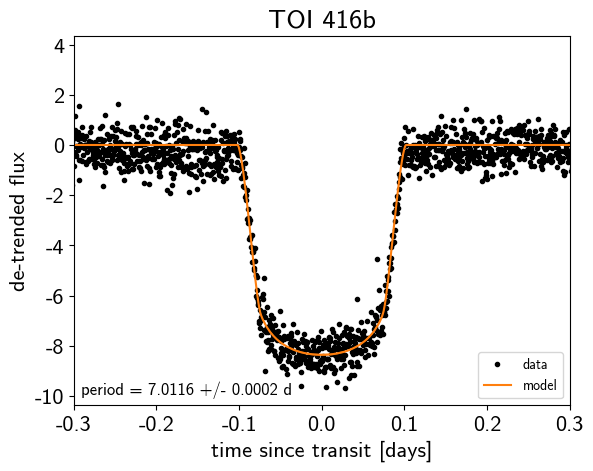

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

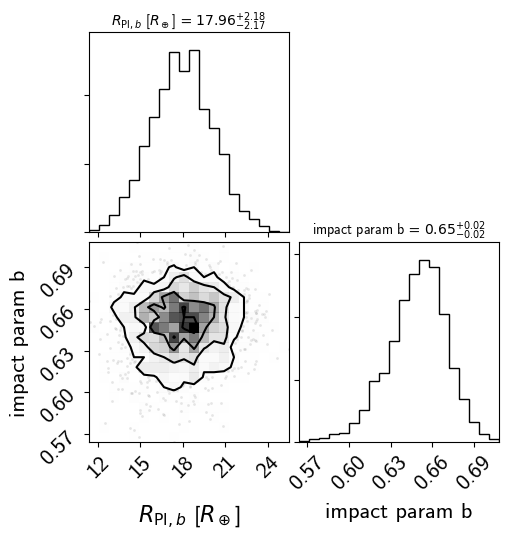

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

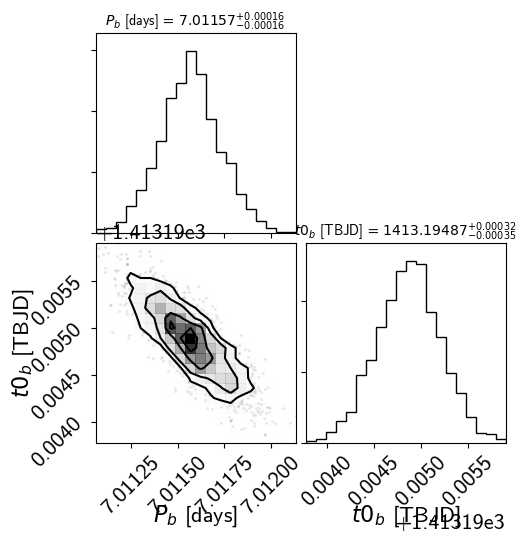

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

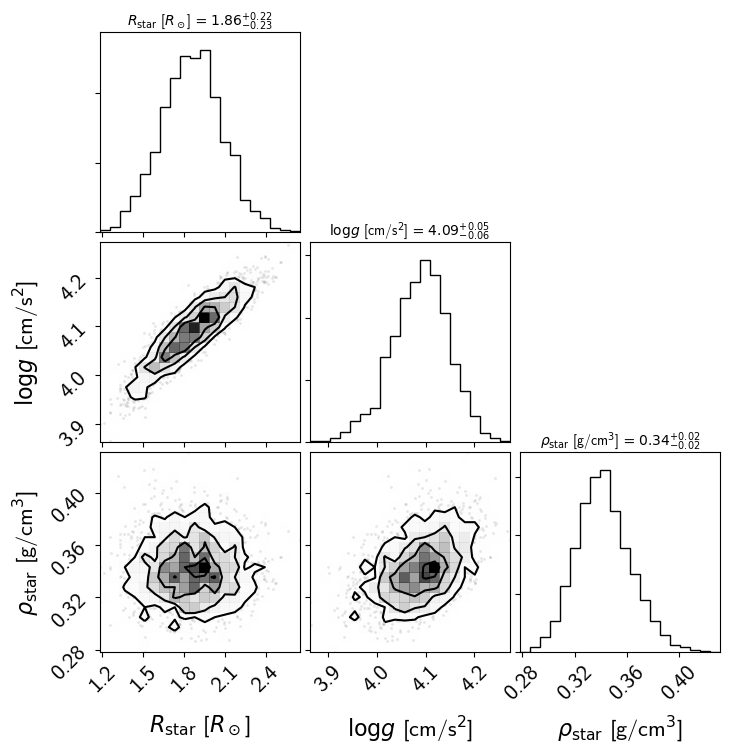

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3